In [1]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np, time
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

In [2]:
# Read data
# Change data path on your computer
data_path = 'earthquakes.csv'
data = pd.read_csv(data_path)
# Print the data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1137 non-null   object 
 1   magnitude        1137 non-null   float64
 2   type             1137 non-null   object 
 3   title            1137 non-null   object 
 4   date             1137 non-null   object 
 5   time             1137 non-null   int64  
 6   updated          1137 non-null   int64  
 7   url              1137 non-null   object 
 8   detailUrl        1137 non-null   object 
 9   felt             1137 non-null   int64  
 10  cdi              1137 non-null   int64  
 11  mmi              1137 non-null   int64  
 12  alert            764 non-null    object 
 13  status           1137 non-null   object 
 14  tsunami          1137 non-null   int64  
 15  sig              1137 non-null   int64  
 16  net              1137 non-null   object 
 17  code          

In [3]:
# Remove some features that aren't important for classify / clustering the alert of the earthquake
# Feature 'date' is already converted to float type in the original dataset 
data.drop(['id', 'date', 'title', 'url', 'detailUrl', 'ids', 'sources',
           'types', 'net', 'code', 'geometryType', 'status',
           'postcode', 'what3words', 'locationDetails'], axis=1, inplace=True)

# Replace Null value of column 'alert' to unknown 
data.fillna({'alert': 'unknown'}, inplace=True)

# NA-value columns will be filled by 'unknown' value
na_column = data.columns[data.isna().any()].tolist()

for column in na_column:
    data.fillna({column: 'unknown'}, inplace=True)

# String-value columns will be one-hot coding
string_columns = data.select_dtypes(include=['object']).columns.tolist()
string_columns.remove('alert')

# One-hot coding
for column in string_columns:
    dummies = pd.get_dummies(data[column], prefix='type')
    data.drop([column], axis=1, inplace=True)
    data = pd.concat([data, dummies], axis=1)

pd.DataFrame(data)

,magnitude,time,updated,felt,cdi,mmi,alert,tsunami,sig,nst,...,type_Wushi,type_Yakutat,type_Yamgan,type_Yucaipa,type_Yucca Flat,type_Zaybak,type_Zendeh Jan District,type_دهستان جلگه چاه هاشم,type_دهستان مورموری,type_دهستان گهره
0,4.8,1726534182289,1726583895255,1893,6,5,green,0,994,37,...,False,False,False,False,False,False,False,False,False,False
1,5.1,1726534182183,1726672002991,2042,6,5,green,0,1040,24,...,False,False,False,False,False,False,False,False,False,False
2,3.7,1726485728190,1726637414586,1580,4,4,unknown,0,591,135,...,False,False,False,False,False,False,False,False,False,False
3,3.9,1726333266539,1726584426218,5,3,4,green,0,236,38,...,False,False,False,False,False,False,False,False,False,False
4,4.1,1726333266382,1726334616179,4,3,4,green,0,260,28,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1132,6.3,1696662769702,1702589215040,11,9,8,orange,0,1010,244,...,False,False,False,False,False,False,True,False,False,False
1133,5.4,1696661381156,1702589215040,0,0,7,yellow,0,650,165,...,False,False,False,False,False,False,True,False,False,False
1134,6.3,1696660863327,1702589215040,19,8,8,orange,0,1014,279,...,False,False,False,False,False,False,True,False,False,False
1135,5.7,1696324863018,1702589211040,131,8,7,green,0,605,226,...,False,False,False,False,False,False,False,False,False,False


In [4]:
# Sample set x_data and label set y_data 
x_data = data.drop(['alert'], axis=1)
x_data = StandardScaler().fit_transform(x_data)
y_data = data['alert']

In [5]:
# Function to split the training set and validation set
def split_data(x_data, y_data, test_size):
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size=test_size,
                                                        random_state=42)
    return x_train, x_test, y_train, y_test

In [6]:
x_train, x_test, y_train, y_test=split_data(x_data, y_data, 0.2)

In [7]:
def evaluate_model(start_time, end_time, y_test_reg, y_pred):
    print(f'Training time: {end_time - start_time}s')
    print(f'Mean Square Error: {mean_squared_error(y_test_reg, y_pred)}')
    print(f'R2 Score: {r2_score(y_test_reg, y_pred)}')

### Thực hiện trên dữ liệu gốc

In [34]:
def svm_to_lasso_regression_original_1(x_train, y_train):
    # Train the model
    svm = SVC(kernel='linear', decision_function_shape='ovr', probability=True)
    svm.fit(x_train, y_train)
    
    label_encoder = LabelEncoder()
    label_encoder.fit_transform(y_data)
    
    decision_scores = svm.decision_function(x_data)
    green_class_index = np.where(label_encoder.classes_ == "green")[0][0] 
    decision_scores_green = decision_scores[:, green_class_index]
    
    # -----------------------------------REGRESSION PROBLEMS------------------------------------------------------------------
    x_data_regression = x_data
    y_data_regression = decision_scores_green
    
    x_train_reg, x_test_reg, y_train_reg, y_test_reg = split_data(x_data_regression, y_data_regression, test_size = 0.2)
    
    # Train model
    start_time = time.perf_counter()
    lasso = Lasso(alpha=0.01, random_state=42)
    lasso.fit(x_train_reg, y_train_reg)
    end_time = time.perf_counter()
    
    # Predict
    y_pred = lasso.predict(x_test_reg)
    
    evaluate_model(start_time, end_time, y_test_reg, y_pred)
    
   
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Giá trị thực
    ax.scatter(x_test_reg[:, 0], x_test_reg[:, 1], y_test_reg, color='blue', label='Actual Values')

    # Giá trị dự đoán
    ax.scatter(x_test_reg[:, 0], x_test_reg[:, 1], y_pred, color='red', label='Predicted Values')
    
    ax.set_title('Lasso Regression: Actual vs Predicted in 3D')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Target')
    ax.legend()
    plt.show()

In [9]:
def svm_to_lasso_regression_original_2(x_train, y_train):
    # Train the model
    svm = SVC(kernel='linear', decision_function_shape='ovr', probability=True)
    svm.fit(x_train, y_train)
    
    label_encoder = LabelEncoder()
    label_encoder.fit_transform(y_data)
    
    decision_scores = svm.decision_function(x_data)
    green_class_index = np.where(label_encoder.classes_ == "green")[0][0] 
    decision_scores_green = decision_scores[:, green_class_index]
    
    # -----------------------------------REGRESSION PROBLEMS------------------------------------------------------------------
    x_data_regression = x_data
    y_data_regression = decision_scores_green
    
    x_train_reg, x_test_reg, y_train_reg, y_test_reg = split_data(x_data_regression, y_data_regression, test_size = 0.3)
    
    # Train model
    start_time = time.perf_counter()
    lasso = Lasso(alpha=0.1, random_state=42)
    lasso.fit(x_train_reg, y_train_reg)
    end_time = time.perf_counter()
    
    # Predict
    y_pred = lasso.predict(x_test_reg)

    evaluate_model(start_time, end_time, y_test_reg, y_pred)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Giá trị thực
    ax.scatter(x_test_reg[:, 0], x_test_reg[:, 1], y_test_reg, color='blue', label='Actual Values')

    # Giá trị dự đoán
    ax.scatter(x_test_reg[:, 0], x_test_reg[:, 1], y_pred, color='red', label='Predicted Values')
    
    ax.set_title('Lasso Regression After PCA: Actual vs Predicted in 3D')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Target')
    ax.legend()
    plt.show()

In [10]:
def svm_to_lasso_regression_original_3(x_train, y_train):
    # Train the model
    svm = SVC(kernel='linear', decision_function_shape='ovr', probability=True)
    svm.fit(x_train, y_train)
    
    label_encoder = LabelEncoder()
    label_encoder.fit_transform(y_data)
    
    decision_scores = svm.decision_function(x_data)
    green_class_index = np.where(label_encoder.classes_ == "green")[0][0] 
    decision_scores_green = decision_scores[:, green_class_index]

    
    # -----------------------------------REGRESSION PROBLEMS------------------------------------------------------------------
    x_data_regression = x_data
    y_data_regression = decision_scores_green
    
    x_train_reg, x_test_reg, y_train_reg, y_test_reg = split_data(x_data_regression, y_data_regression, test_size = 0.4)
    
    # Train model
    start_time = time.perf_counter()
    lasso = Lasso(alpha=0.1, random_state=42)
    lasso.fit(x_train_reg, y_train_reg)
    end_time = time.perf_counter()
    
    # Predict
    y_pred = lasso.predict(x_test_reg)
    
    evaluate_model(start_time, end_time, y_test_reg, y_pred)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Giá trị thực
    ax.scatter(x_test_reg[:, 0], x_test_reg[:, 1], y_test_reg, color='blue', label='Actual Values')

    # Giá trị dự đoán
    ax.scatter(x_test_reg[:, 0], x_test_reg[:, 1], y_pred, color='red', label='Predicted Values')
    
    ax.set_title('Lasso Regression: Actual vs Predicted in 3D')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Target')
    ax.legend()
    plt.show()

In [11]:
def svm_to_linear_regression_original_1(x_train, y_train):
    # Train the model
    svm = SVC(kernel='linear', decision_function_shape='ovr', probability=True)
    svm.fit(x_train, y_train)
    
    label_encoder = LabelEncoder()
    label_encoder.fit_transform(y_data)
    
    decision_scores = svm.decision_function(x_data)
    green_class_index = np.where(label_encoder.classes_ == "green")[0][0] 
    decision_scores_green = decision_scores[:, green_class_index]

    
    # -----------------------------------REGRESSION PROBLEMS------------------------------------------------------------------
    x_data_regression = x_data
    y_data_regression = decision_scores_green
    
    x_train_reg, x_test_reg, y_train_reg, y_test_reg=split_data(x_data_regression, y_data_regression, 0.2)
    
    # Train model
    start_time = time.perf_counter()
    linear = LinearRegression()
    linear.fit(x_train_reg, y_train_reg)
    end_time = time.perf_counter()
    
    # Predict
    y_pred = linear.predict(x_test_reg)

    evaluate_model(start_time, end_time, y_test_reg, y_pred)

In [12]:
def svm_to_linear_regression_original_2(x_train, y_train):
    # Train the model
    svm = SVC(kernel='linear', decision_function_shape='ovr', probability=True)
    svm.fit(x_train, y_train)
    
    label_encoder = LabelEncoder()
    label_encoder.fit_transform(y_data)
    
    decision_scores = svm.decision_function(x_data)
    green_class_index = np.where(label_encoder.classes_ == "green")[0][0] 
    decision_scores_green = decision_scores[:, green_class_index]

    
    # -----------------------------------REGRESSION PROBLEMS------------------------------------------------------------------
    x_data_regression = x_data
    y_data_regression = decision_scores_green
    
    x_train_reg, x_test_reg, y_train_reg, y_test_reg=split_data(x_data_regression, y_data_regression, 0.3)
    
    # Train model
    start_time = time.perf_counter()
    linear = LinearRegression()
    linear.fit(x_train_reg, y_train_reg)
    end_time = time.perf_counter()
    
    # Predict
    y_pred = linear.predict(x_test_reg)

    evaluate_model(start_time, end_time, y_test_reg, y_pred)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Giá trị thực
    ax.scatter(x_test_reg[:, 0], x_test_reg[:, 1], y_test_reg, color='blue', label='Actual Values')

    # Giá trị dự đoán
    ax.scatter(x_test_reg[:, 0], x_test_reg[:, 1], y_pred, color='red', label='Predicted Values')
    
    ax.set_title('Linear Regression: Actual vs Predicted in 3D')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Target')
    ax.legend()
    plt.show()

In [13]:
def svm_to_linear_regression_original_3(x_train, y_train):
    # Train the model
    svm = SVC(kernel='linear', decision_function_shape='ovr', probability=True)
    svm.fit(x_train, y_train)
    
    label_encoder = LabelEncoder()
    label_encoder.fit_transform(y_data)
    
    decision_scores = svm.decision_function(x_data)
    green_class_index = np.where(label_encoder.classes_ == "green")[0][0] 
    decision_scores_green = decision_scores[:, green_class_index]

    
    # -----------------------------------REGRESSION PROBLEMS------------------------------------------------------------------
    x_data_regression = x_data
    y_data_regression = decision_scores_green
    
    x_train_reg, x_test_reg, y_train_reg, y_test_reg=split_data(x_data_regression, y_data_regression, 0.4)
    
    # Train model
    start_time = time.perf_counter()
    linear = LinearRegression()
    linear.fit(x_train_reg, y_train_reg)
    end_time = time.perf_counter()
    
    # Predict
    y_pred = linear.predict(x_test_reg)

    evaluate_model(start_time, end_time, y_test_reg, y_pred)

### Thực hiện trên dữ liệu đã giảm còn $\dfrac{1}{3}$ số chiều 


In [14]:
def svm_to_lasso_regression_pca_1(x_train, y_train):
    # Train the model
    svm = SVC(kernel='linear', decision_function_shape='ovr', probability=True)
    svm.fit(x_train, y_train)
    
    label_encoder = LabelEncoder()
    label_encoder.fit_transform(y_data)
    
    decision_scores = svm.decision_function(x_data)
    green_class_index = np.where(label_encoder.classes_ == "green")[0][0] 
    decision_scores_green = decision_scores[:, green_class_index]

    
    # -----------------------------------REGRESSION PROBLEMS------------------------------------------------------------------
    x_data_regression = x_data
    y_data_regression = decision_scores_green
    
    # Dimensionality reduction
    # Using PCA method
    x_data_regression = StandardScaler().fit_transform(x_data_regression)
    pca_plot = PCA(n_components=50, random_state=42)
    x_data_pca_reg = pca_plot.fit_transform(x_data_regression)
    
    x_train_reg, x_test_reg, y_train_reg, y_test_reg=split_data(x_data_pca_reg, y_data_regression, 0.2)
    
    # Train model
    start_time = time.perf_counter()
    lasso = Lasso(alpha=0.1, random_state=42)
    lasso.fit(x_train_reg, y_train_reg)
    end_time = time.perf_counter()
    
    # Predict
    y_pred = lasso.predict(x_test_reg)
    
    evaluate_model(start_time, end_time, y_test_reg, y_pred)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Giá trị thực
    ax.scatter(x_test_reg[:, 0], x_test_reg[:, 1], y_test_reg, color='blue', label='Actual Values')

    # Giá trị dự đoán
    ax.scatter(x_test_reg[:, 0], x_test_reg[:, 1], y_pred, color='red', label='Predicted Values')
    
    ax.set_title('Lasso Regression: Actual vs Predicted in 3D')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Target')
    ax.legend()
    plt.show()

In [15]:
def svm_to_lasso_regression_pca_2(x_train, y_train):
    # Train the model
    svm = SVC(kernel='linear', decision_function_shape='ovr', probability=True)
    svm.fit(x_train, y_train)
    
    label_encoder = LabelEncoder()
    label_encoder.fit_transform(y_data)
    
    decision_scores = svm.decision_function(x_data)
    green_class_index = np.where(label_encoder.classes_ == "green")[0][0] 
    decision_scores_green = decision_scores[:, green_class_index]

    
    # -----------------------------------REGRESSION PROBLEMS------------------------------------------------------------------
    x_data_regression = x_data
    y_data_regression = decision_scores_green
    
    # Dimensionality reduction
    # Using PCA method
    x_data_regression = StandardScaler().fit_transform(x_data_regression)
    pca_plot = PCA(n_components=x_data_regression.shape[1] // 3, random_state=42)
    x_data_pca_reg = pca_plot.fit_transform(x_data_regression)
    
    x_train_reg, x_test_reg, y_train_reg, y_test_reg=split_data(x_data_pca_reg, y_data_regression, 0.3)
    
    # Train model
    start_time = time.perf_counter()
    lasso = Lasso(alpha=0.1, random_state=42)
    lasso.fit(x_train_reg, y_train_reg)
    end_time = time.perf_counter()
    
    # Predict
    y_pred = lasso.predict(x_test_reg)
    
    evaluate_model(start_time, end_time, y_test_reg, y_pred)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Giá trị thực
    ax.scatter(x_test_reg[:, 0], x_test_reg[:, 1], y_test_reg, color='blue', label='Actual Values')

    # Giá trị dự đoán
    ax.scatter(x_test_reg[:, 0], x_test_reg[:, 1], y_pred, color='red', label='Predicted Values')
    
    ax.set_title('Lasso Regression After PCA: Actual vs Predicted in 3D')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Target')
    ax.legend()
    plt.show()

In [16]:
def svm_to_lasso_regression_pca_3(x_train, y_train):
    # Train the model
    svm = SVC(kernel='linear', decision_function_shape='ovr', probability=True)
    svm.fit(x_train, y_train)
    
    label_encoder = LabelEncoder()
    label_encoder.fit_transform(y_data)
    
    decision_scores = svm.decision_function(x_data)
    green_class_index = np.where(label_encoder.classes_ == "green")[0][0] 
    decision_scores_green = decision_scores[:, green_class_index]

    
    # -----------------------------------REGRESSION PROBLEMS------------------------------------------------------------------
    x_data_regression = x_data
    y_data_regression = decision_scores_green
    
    # Dimensionality reduction
    # Using PCA method
    x_data_regression = StandardScaler().fit_transform(x_data_regression)
    pca_plot = PCA(n_components=x_data_regression.shape[1] // 3, random_state=42)
    x_data_pca_reg = pca_plot.fit_transform(x_data_regression)
    
    x_train_reg, x_test_reg, y_train_reg, y_test_reg=split_data(x_data_pca_reg, y_data_regression, 0.4)
    
    # Train model
    start_time = time.perf_counter()
    lasso = Lasso(alpha=0.1, random_state=42)
    lasso.fit(x_train_reg, y_train_reg)
    end_time = time.perf_counter()
    
    # Predict
    y_pred = lasso.predict(x_test_reg)
    
    evaluate_model(start_time, end_time, y_test_reg, y_pred)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Giá trị thực
    ax.scatter(x_test_reg[:, 0], x_test_reg[:, 1], y_test_reg, color='blue', label='Actual Values')

    # Giá trị dự đoán
    ax.scatter(x_test_reg[:, 0], x_test_reg[:, 1], y_pred, color='red', label='Predicted Values')
    
    ax.set_title('Lasso Regression: Actual vs Predicted in 3D')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Target')
    ax.legend()
    plt.show()

In [17]:
def svm_to_linear_regression_pca_1(x_train, y_train):
    # Train the model
    svm = SVC(kernel='linear', decision_function_shape='ovr', probability=True)
    svm.fit(x_train, y_train)
    
    label_encoder = LabelEncoder()
    label_encoder.fit_transform(y_data)
    
    decision_scores = svm.decision_function(x_data)
    green_class_index = np.where(label_encoder.classes_ == "green")[0][0] 
    decision_scores_green = decision_scores[:, green_class_index]

    
    # -----------------------------------REGRESSION PROBLEMS------------------------------------------------------------------
    x_data_regression = x_data
    y_data_regression = decision_scores_green
    
    # Dimensionality reduction
    # Using PCA method
    x_data_regression = StandardScaler().fit_transform(x_data_regression)
    pca_plot = PCA(n_components=x_data_regression.shape[1] // 3, random_state=42)
    x_data_pca_reg = pca_plot.fit_transform(x_data_regression)
    
    x_train_reg, x_test_reg, y_train_reg, y_test_reg=split_data(x_data_pca_reg, y_data_regression, 0.2)
    
    # Train model
    start_time = time.perf_counter()
    linear = LinearRegression()
    linear.fit(x_train_reg, y_train_reg)
    end_time = time.perf_counter()
    
    # Predict
    y_pred = linear.predict(x_test_reg)
    
    evaluate_model(start_time, end_time, y_test_reg, y_pred)

In [18]:
def svm_to_linear_regression_pca_2(x_train, y_train):
    # Train the model
    svm = SVC(kernel='linear', decision_function_shape='ovr', probability=True)
    svm.fit(x_train, y_train)
    
    label_encoder = LabelEncoder()
    label_encoder.fit_transform(y_data)
    
    decision_scores = svm.decision_function(x_data)
    green_class_index = np.where(label_encoder.classes_ == "green")[0][0] 
    decision_scores_green = decision_scores[:, green_class_index]

    
    # -----------------------------------REGRESSION PROBLEMS------------------------------------------------------------------
    x_data_regression = x_data
    y_data_regression = decision_scores_green
    
    # Dimensionality reduction
    # Using PCA method
    x_data_regression = StandardScaler().fit_transform(x_data_regression)
    pca_plot = PCA(n_components=x_data_regression.shape[1] // 3, random_state=42)
    x_data_pca_reg = pca_plot.fit_transform(x_data_regression)
    
    x_train_reg, x_test_reg, y_train_reg, y_test_reg=split_data(x_data_pca_reg, y_data_regression, 0.3)
    
    # Train model
    start_time = time.perf_counter()
    linear = LinearRegression()
    linear.fit(x_train_reg, y_train_reg)
    end_time = time.perf_counter()
    
    # Predict
    y_pred = linear.predict(x_test_reg)
    
    evaluate_model(start_time, end_time, y_test_reg, y_pred)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Giá trị thực
    ax.scatter(x_test_reg[:, 0], x_test_reg[:, 1], y_test_reg, color='blue', label='Actual Values')

    # Giá trị dự đoán
    ax.scatter(x_test_reg[:, 0], x_test_reg[:, 1], y_pred, color='red', label='Predicted Values')
    
    ax.set_title('Linear Regression After PCA: Actual vs Predicted in 3D')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Target')
    ax.legend()
    plt.show()

In [19]:
def svm_to_linear_regression_pca_3(x_train, y_train):
    # Train the model
    svm = SVC(kernel='linear', decision_function_shape='ovr', probability=True)
    svm.fit(x_train, y_train)
    
    label_encoder = LabelEncoder()
    label_encoder.fit_transform(y_data)
    
    decision_scores = svm.decision_function(x_data)
    green_class_index = np.where(label_encoder.classes_ == "green")[0][0] 
    decision_scores_green = decision_scores[:, green_class_index]

    
    # -----------------------------------REGRESSION PROBLEMS------------------------------------------------------------------
    x_data_regression = x_data
    y_data_regression = decision_scores_green
    
    # Dimensionality reduction
    # Using PCA method
    x_data_regression = StandardScaler().fit_transform(x_data_regression)
    pca_plot = PCA(n_components=x_data_regression.shape[1] // 3, random_state=42)
    x_data_pca_reg = pca_plot.fit_transform(x_data_regression)
    
    x_train_reg, x_test_reg, y_train_reg, y_test_reg=split_data(x_data_pca_reg, y_data_regression, 0.4)
    
    # Train model
    start_time = time.perf_counter()
    linear = LinearRegression()
    linear.fit(x_train_reg, y_train_reg)
    end_time = time.perf_counter()
    
    # Predict
    y_pred = linear.predict(x_test_reg)
    
    evaluate_model(start_time, end_time, y_test_reg, y_pred)

### Dữ liệu gốc

#### Lasso Regression

***Tỷ lệ train:test là 4:1***

-0.2623063220205409 4.314906224512914
Training time: 0.34366219997173175s
Mean Square Error: 0.08112713118751587
R2 Score: 0.7955883890256681


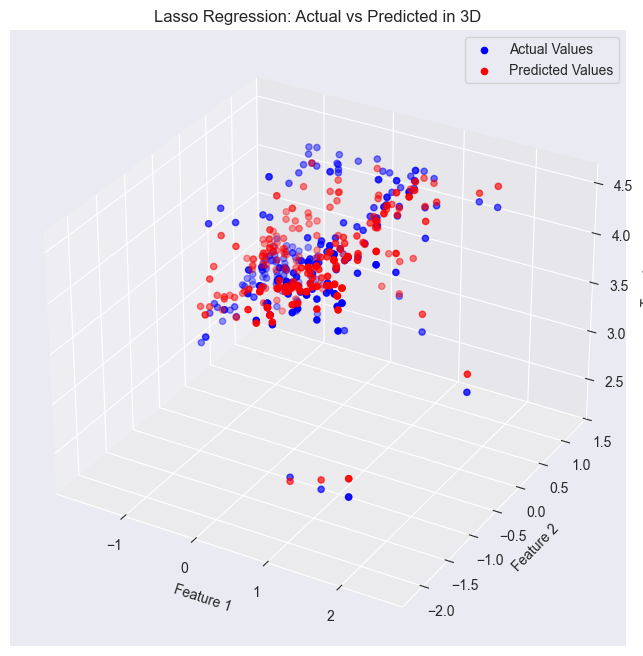

In [35]:
svm_to_lasso_regression_original_1(x_train, y_train)

***Tỷ lệ train:test là 7:3***

Training time: 0.057302000001072884s
Mean Square Error: 0.1707320259723026
R2 Score: 0.5598543960511964


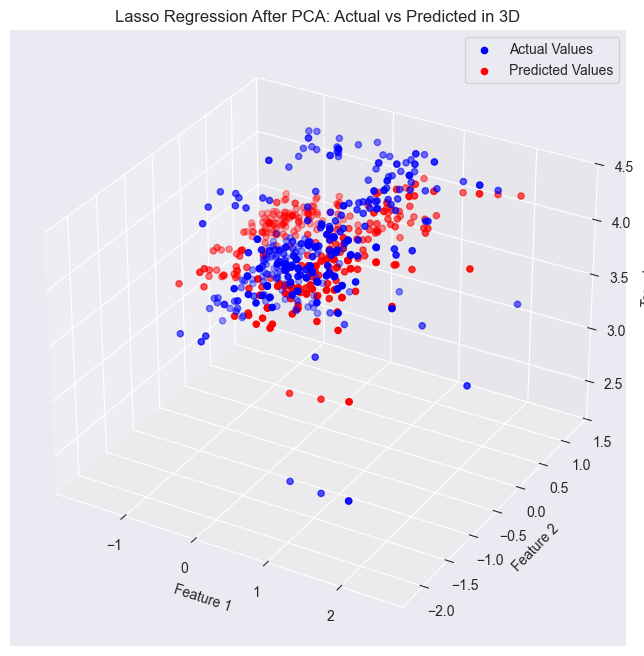

In [21]:
svm_to_lasso_regression_original_2(x_train, y_train)

***Tỷ lệ train:test là 6:4***

Training time: 0.03533799998695031s
Mean Square Error: 0.17005289335598936
R2 Score: 0.553531194289896


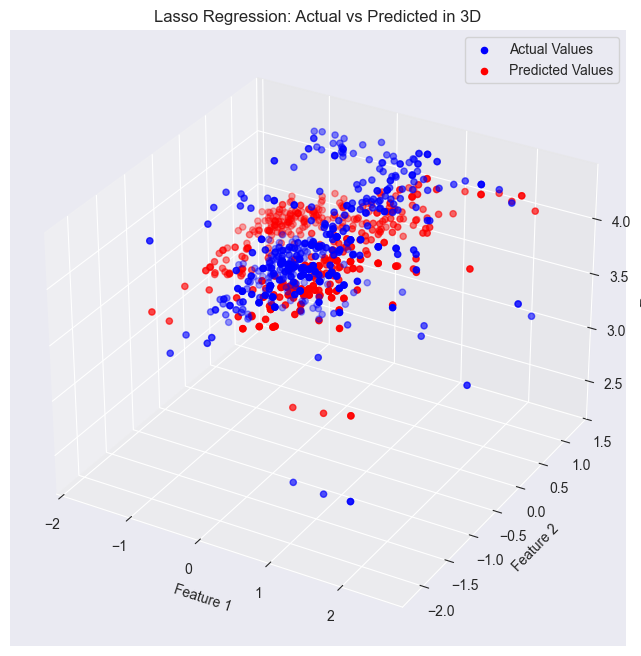

In [22]:
svm_to_lasso_regression_original_3(x_train, y_train)

#### Linear Regression

***Tỷ lệ train:test là 4:1***

In [23]:
svm_to_linear_regression_original_1(x_train, y_train)

Training time: 0.5656910000252537s
Mean Square Error: 7.8042972455555e+26
R2 Score: -1.9664062430596955e+27


***Tỷ lệ train:test là 7:3***

Training time: 0.30972449999535456s
Mean Square Error: 9.150127546056964e+26
R2 Score: -2.3588945261044226e+27


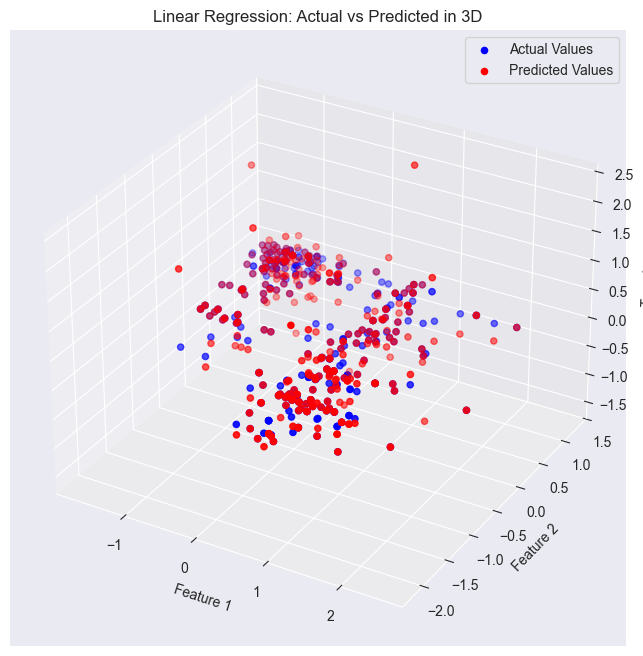

In [24]:
svm_to_linear_regression_original_2(x_train, y_train)

***Tỷ lệ train:test là 6:4***

In [25]:
svm_to_linear_regression_original_3(x_train, y_train)

Training time: 0.22918729996308684s
Mean Square Error: 4.738143004942889e+26
R2 Score: -1.2439853312416626e+27


### Dữ liệu đã giảm còn $\dfrac{1}{3}$ số chiều

#### Lasso Regression

***Tỷ lệ train:test là 4:1***

Training time: 0.0012889000354334712s
Mean Square Error: 0.23019468265523044
R2 Score: 0.41999100386626675


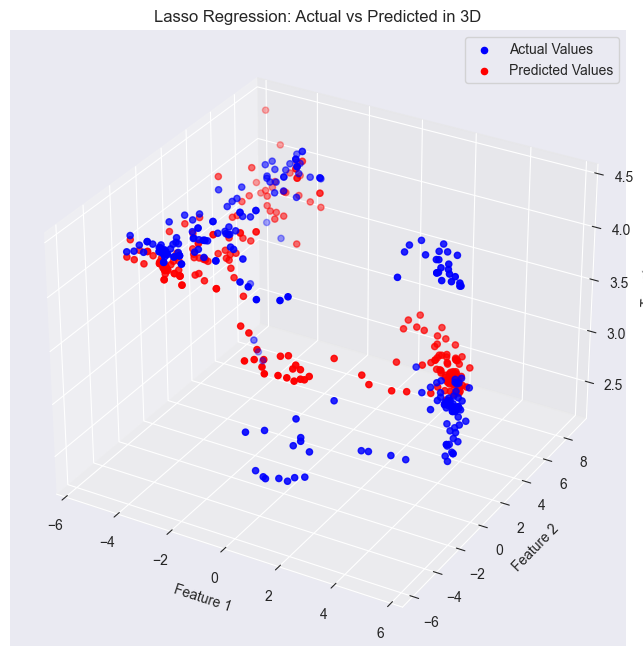

In [26]:
svm_to_lasso_regression_pca_1(x_train, y_train)

***Tỷ lệ train:test là 7:3***

Training time: 0.00800370000069961s
Mean Square Error: 0.1869992154091954
R2 Score: 0.5179177302237065


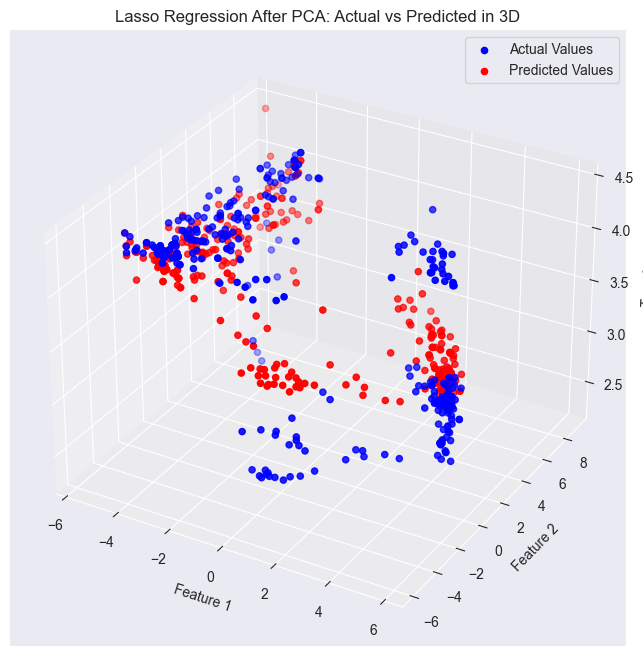

In [27]:
svm_to_lasso_regression_pca_2(x_train, y_train)

***Tỷ lệ train:test là 6:4***

Training time: 0.008922600012738258s
Mean Square Error: 0.1813948589642867
R2 Score: 0.5237532014571545


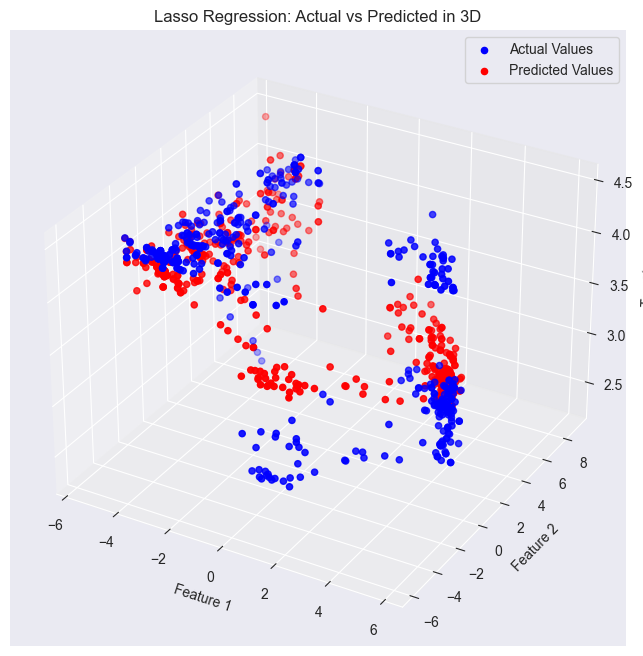

In [28]:
svm_to_lasso_regression_pca_3(x_train, y_train)

#### Linear Regression

***Tỷ lệ train:test là 4:1***

In [29]:
svm_to_linear_regression_pca_1(x_train, y_train)

Training time: 0.10397439997177571s
Mean Square Error: 4.8319221497261493e+27
R2 Score: -1.2174730897917789e+28


***Tỷ lệ train:test là 7:3***

Training time: 0.09298869996564463s
Mean Square Error: 9.226973944676339e+27
R2 Score: -2.3787054574976355e+28


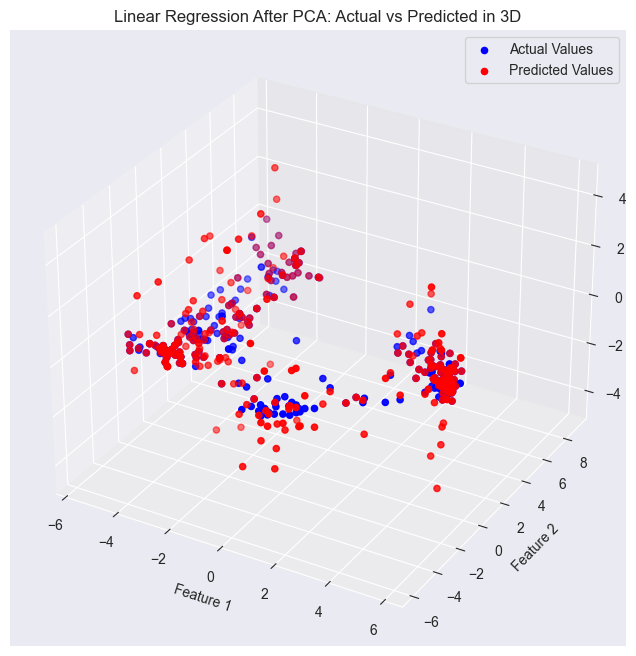

In [30]:
svm_to_linear_regression_pca_2(x_train, y_train)

***Tỷ lệ train:test là 6:4***

In [31]:
svm_to_linear_regression_pca_3(x_train, y_train)

Training time: 0.14052519999677315s
Mean Square Error: 6.969179689787489e+27
R2 Score: -1.8297373666938226e+28
